In [ ]:
# Install segmentation models package
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Define path variables
TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size

# Define pretrained encoder model and weights
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

Load Data

In [ ]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


Explore the Data

In [ ]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

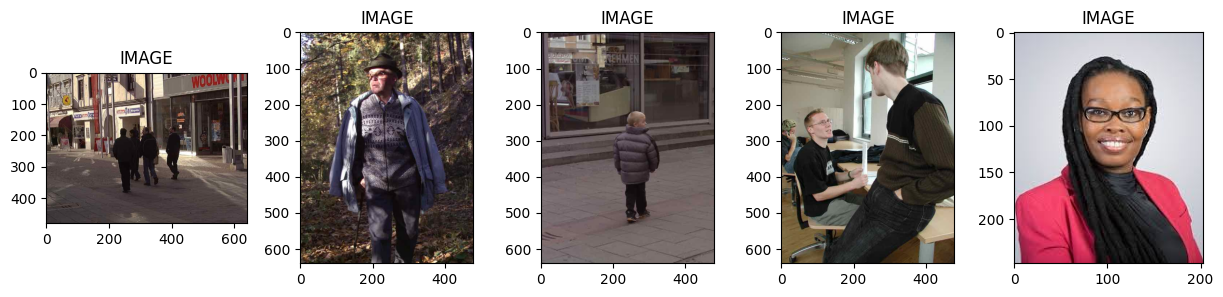

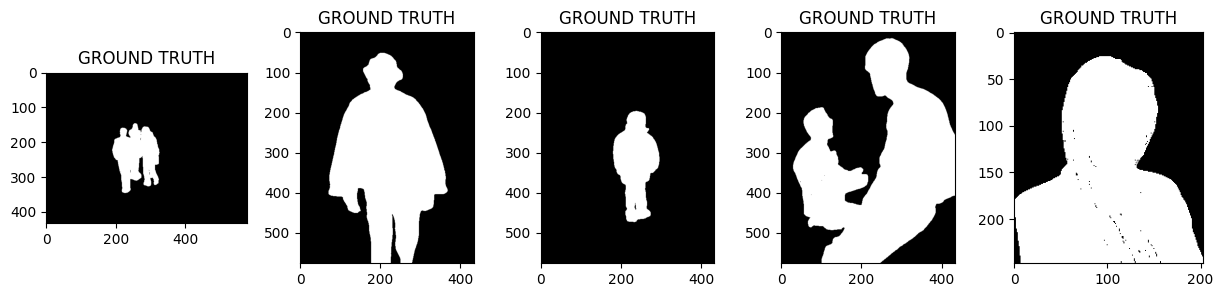

In [ ]:
generate_sample_images(sample)
generate_sample_masks(sample)

Split the Data

In [ ]:
# Split data in separate train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

Data Augnebtation

In [ ]:
# image augmentation library
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

Processing the Dataset: (channels, Height, Width) format, /255 normalization

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# Create a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        #print(f"Shapes of images before augmentation: {image.shape}")
        #print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        #print(f"\nShapes of images after augmentation: {image.shape}")
        #print(f"Shapes of masks after augmentation: {mask.shape}")

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [ ]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


Sample image, mask pair:

In [ ]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()

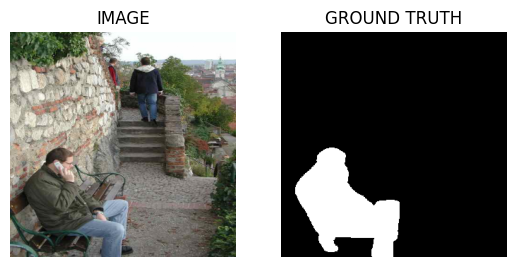

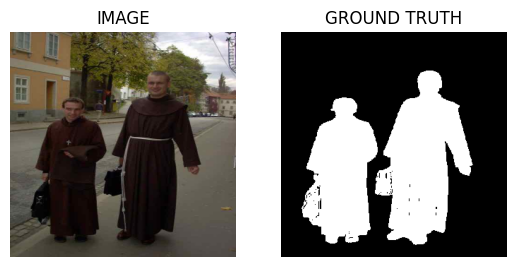

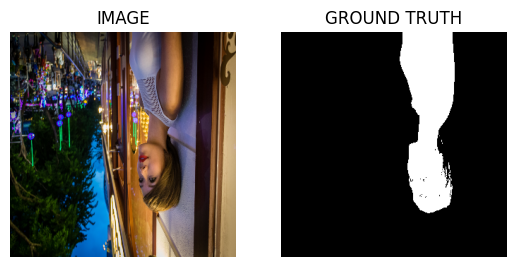

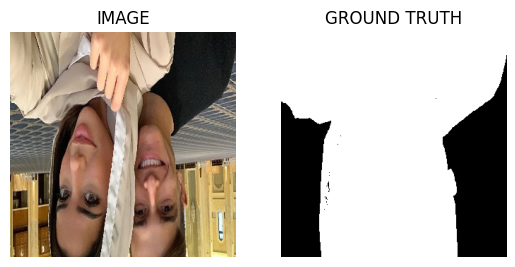

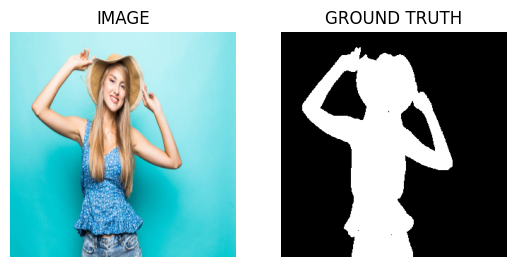

In [ ]:
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 2


In [ ]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([32, 3, 320, 320])
Size of one batch of masks: torch.Size([32, 1, 320, 320])


Create Segmentation Model: based on UNet++


*   efficient net as the encoder model
*   weights from imagenet
*   3 RGB channels





In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks) # measure of dissimilarity between the predicted segmentation mask and the true segmentation
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Create Train and Validation Function

In [ ]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

Model Training

In [ ]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.1864714846014977 Val Loss 2.2942224740982056


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


MODEL SAVED
 Epoch 2 Train Loss 0.672789566218853 Val Loss 0.506210446357727


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


MODEL SAVED
 Epoch 3 Train Loss 0.49315089359879494 Val Loss 0.31999197602272034


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


MODEL SAVED
 Epoch 4 Train Loss 0.3920495994389057 Val Loss 0.3026518225669861


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


 Epoch 5 Train Loss 0.2997944504022598 Val Loss 0.3104642480611801


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


MODEL SAVED
 Epoch 6 Train Loss 0.25261240266263485 Val Loss 0.24860288202762604


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


MODEL SAVED
 Epoch 7 Train Loss 0.19731907919049263 Val Loss 0.24323174357414246


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


MODEL SAVED
 Epoch 8 Train Loss 0.20198570378124714 Val Loss 0.23815790563821793


100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


MODEL SAVED
 Epoch 9 Train Loss 0.1957071889191866 Val Loss 0.22229810059070587


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

MODEL SAVED
 Epoch 10 Train Loss 0.1697887945920229 Val Loss 0.21179240196943283


Inference

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

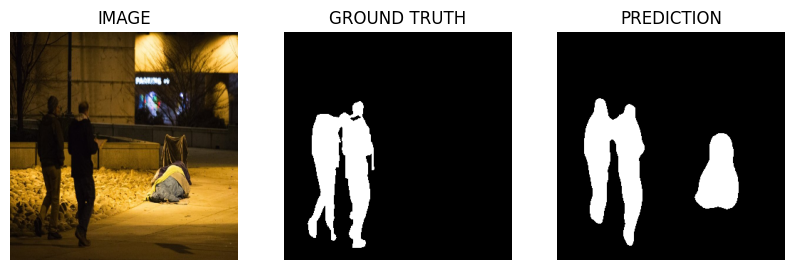

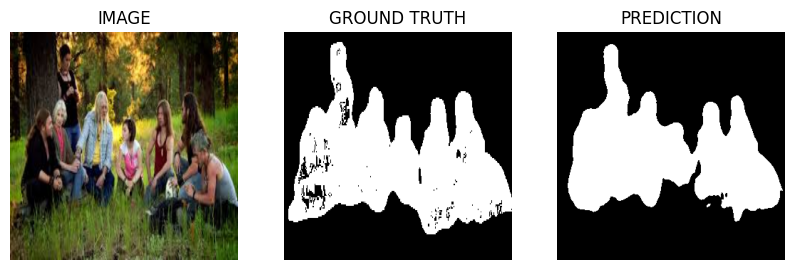

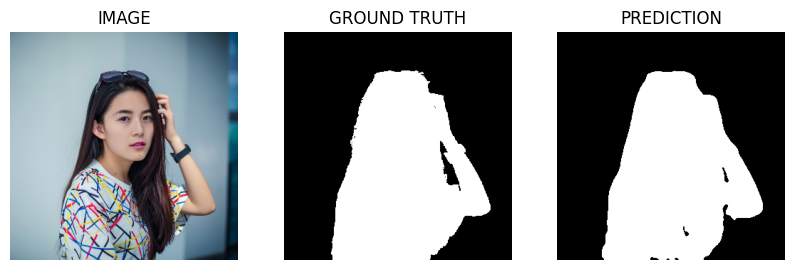

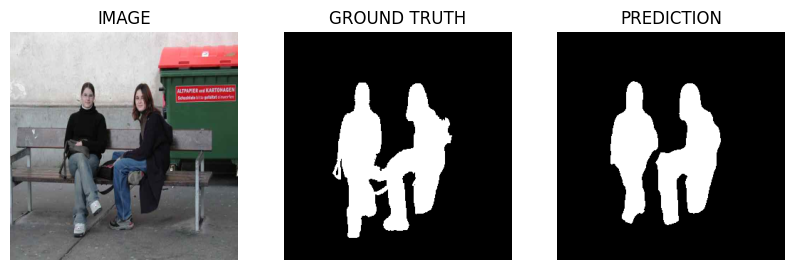

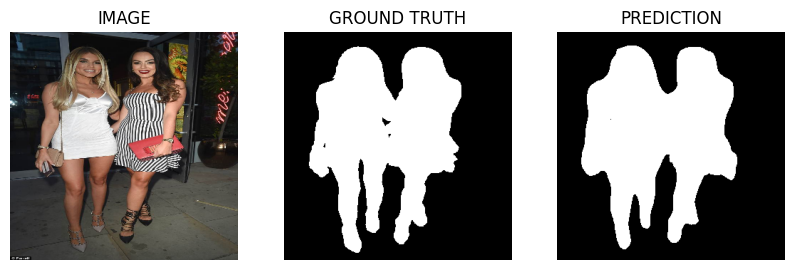

In [ ]:
# Compare predictions with original
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');